In [217]:
del OB_df
OB_df = None

In [218]:
import pandas as pd

OB_df = pd.read_csv('data/raw/raw_open_banking_data.csv')
OB_df.head()

,transaction_id,company_id,transaction_date,transaction_amount,transaction_description,customer_id,payment_method
0,txn_company_1_1,company_1,2024-01-01 00:00:00,2000.0,Capital investment from investor,152,debit_card
1,txn_company_1_2,company_1,2024-01-01 01:00:00,NaN,Refund processed,193,credit_card
2,txn_company_1_3,company_1,2024-01-01 02:00:00,-50.0,Office supplies purchase,115,credit_card
3,txn_company_1_4,company_1,2024-01-01 03:00:00,300.0,Educational toy income,172,credit_card
4,txn_company_1_5,company_1,2024-01-01 04:00:00,2000.0,Rebate from supplier,161,credit_card


# Explore the data

In [208]:
OB_df.shape

(604, 7)

In [209]:
OB_df.columns

Index(['transaction_id', 'company_id', 'transaction_date',
       'transaction_amount', 'transaction_description', 'customer_id',
       'payment_method'],
      dtype='object')

In [210]:
OB_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 604 entries, 0 to 603
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   transaction_id           604 non-null    object 
 1   company_id               604 non-null    object 
 2   transaction_date         604 non-null    object 
 3   transaction_amount       574 non-null    float64
 4   transaction_description  604 non-null    object 
 5   customer_id              604 non-null    int64  
 6   payment_method           604 non-null    object 
dtypes: float64(1), int64(1), object(5)
memory usage: 33.2+ KB


In [211]:
OB_df.describe()

,transaction_amount,customer_id
count,5.740000e+02,604.000000
mean,9.796254e+03,151.266556
std,1.794268e+05,30.115424
min,-2.000000e+06,101.000000
25%,-1.375000e+02,123.000000
50%,3.000000e+02,152.500000
75%,2.000000e+03,179.000000
max,2.000000e+06,200.000000


### Observation
Out of 7 columns, we have 2 numerical columns(one of them is customer_id which is not useful in calculation) and 5 categorical columns

# Data visualisation

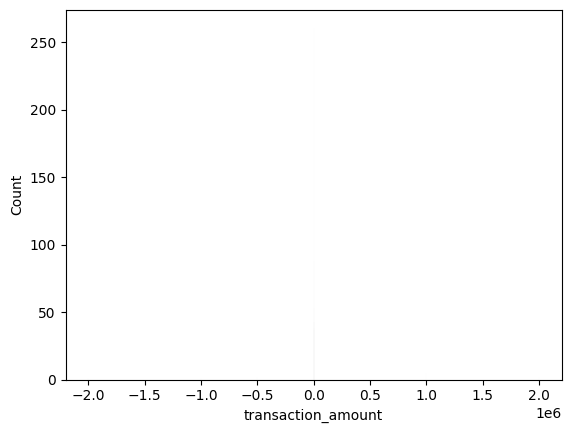

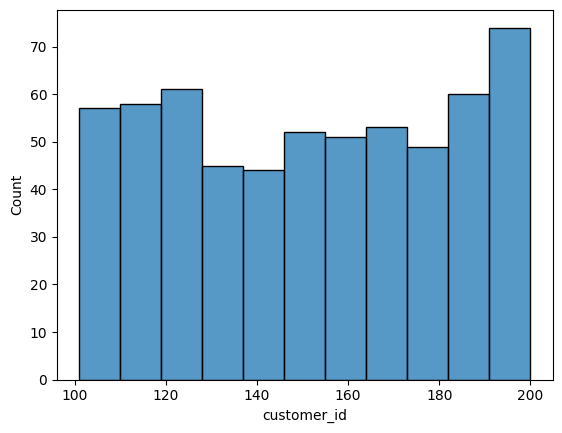

In [219]:
#histogram to understand the distribution
import warnings
from matplotlib import pyplot as plt
warnings.filterwarnings("ignore")
for i in OB_df.select_dtypes(include="number").columns:
    sns.histplot(data=OB_df,x=i)
    plt.show()

### Observations
We are not able to see the plot for transaction_amount values. it may because the values are not in the range, or we have null values. it needs further investigation

# Feature Engineeering

## Categerical data

### Check for high and low cardinality

In [58]:
df_cat = OB_df.select_dtypes(include = ['object'])
df_cat.nunique().sort_values()

payment_method               3
company_id                   5
transaction_description     47
transaction_date           199
transaction_id             575
dtype: int64

## drop the categorical columns with high cardinality

In [187]:
OB_df.drop(columns=['transaction_date', 'transaction_id'], inplace=True)

In [ ]:
## Duplicate data

In [188]:
OB_df.duplicated().sum()

32

In [189]:
OB_df.drop_duplicates(inplace=True)

## Deal with missing values

In [220]:
OB_df.isna().sum()

transaction_id              0
company_id                  0
transaction_date            0
transaction_amount         30
transaction_description     0
customer_id                 0
payment_method              0
dtype: int64

In [59]:
OB_df[OB_df['transaction_amount'].isnull()].groupby('company_id').size()

company_id
company_1     5
company_2     2
company_3    10
company_4     9
company_5     4
dtype: int64

# Observation

Out of 604 samples, 30 of them are null for the transaction_amount, which is approximately the 5% of the data.
Considering that our problem is regression and transaction_amount is our target column, what is the best way to fill the null values?
- drop the null column
  impossible, because the transaction_amount is our target column
- drop the sample with null values
  considering our dataset size is limited, we dont want to loose the data
- fill with mean, median
  we have outlier in our dataset
- fill with random value
- Impute the missing value using KNN
   imputing with KNN Imputer, causes data leakage if the data has not been splitted before imputing
- Analyse the data and research more then choose the proper method
  Target variable is not advised to be imputed, this is because they control how the learning algorithm learns
  5% is not a high percentage so we decide to remove the samples with missing values
  robust models like Random forest/LGM/XGBoost will automatically handle missing values but not the target

In [221]:
OB_df = OB_df.dropna(subset=['transaction_amount'])

In [18]:
! pip install matplotlib

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


In [26]:
grouped_company_customer = OB_df.groupby(['company_id', 'customer_id']).size()
grouped_company_customer.head()

company_id  customer_id
company_1   102            5
            103            2
            104            3
            106            1
            107            1
dtype: int64

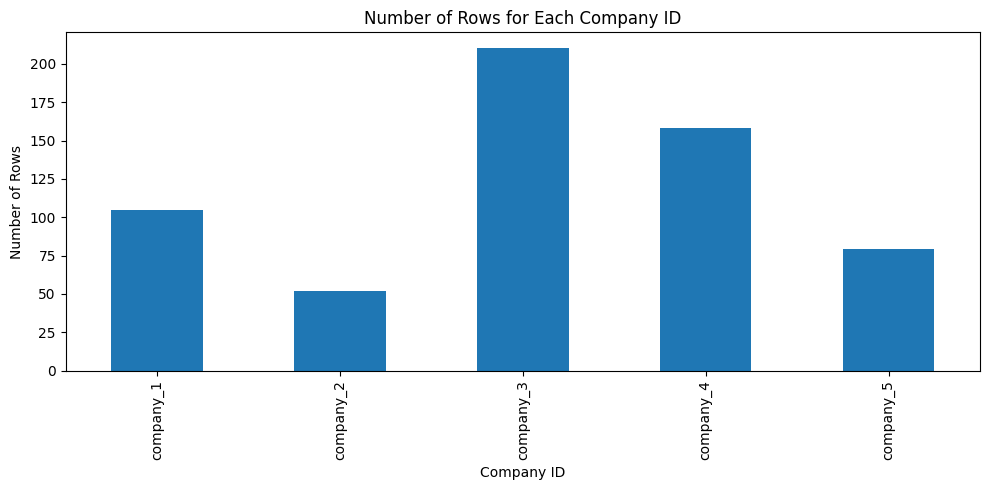

In [20]:
from matplotlib import pyplot as plt

# Group by 'company_id' and count the number of rows in each group
grouped_company = OB_df.groupby('company_id').size()

# Plotting the distribution for each company_id
plt.figure(figsize=(10, 5))

grouped_company.plot(kind='bar')
plt.title('Number of Rows for Each Company ID')
plt.xlabel('Company ID')
plt.ylabel('Number of Rows')

plt.tight_layout()
plt.show()

# Observation
We dont have a balance dataset, the company_3 has more samples than the other companies, which may cause the model to bias to it

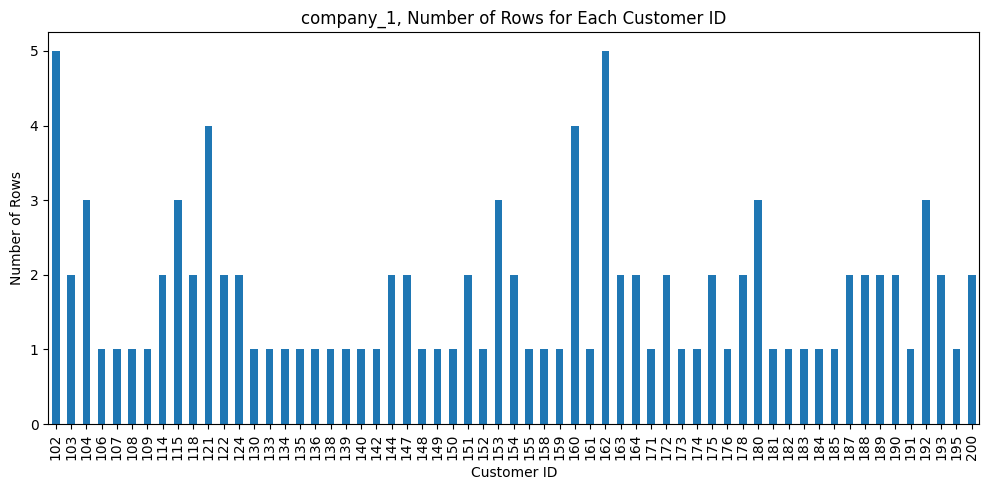

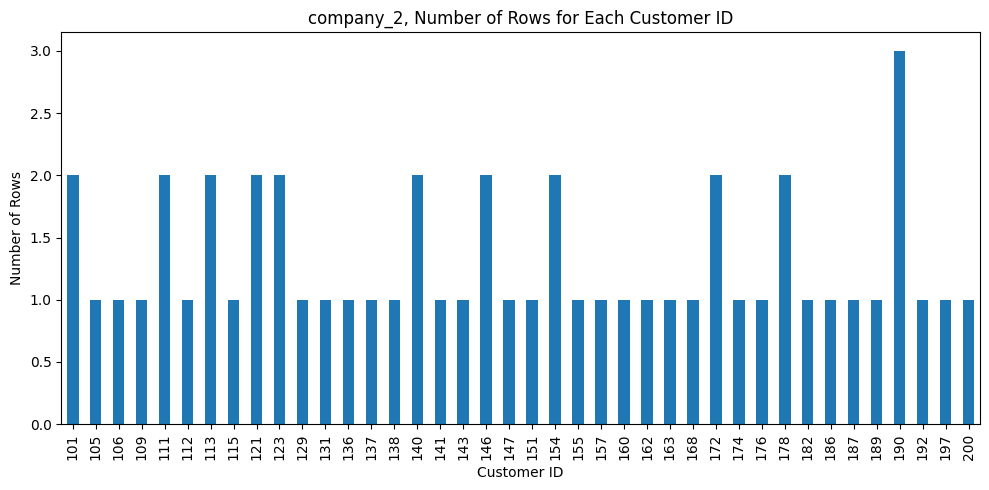

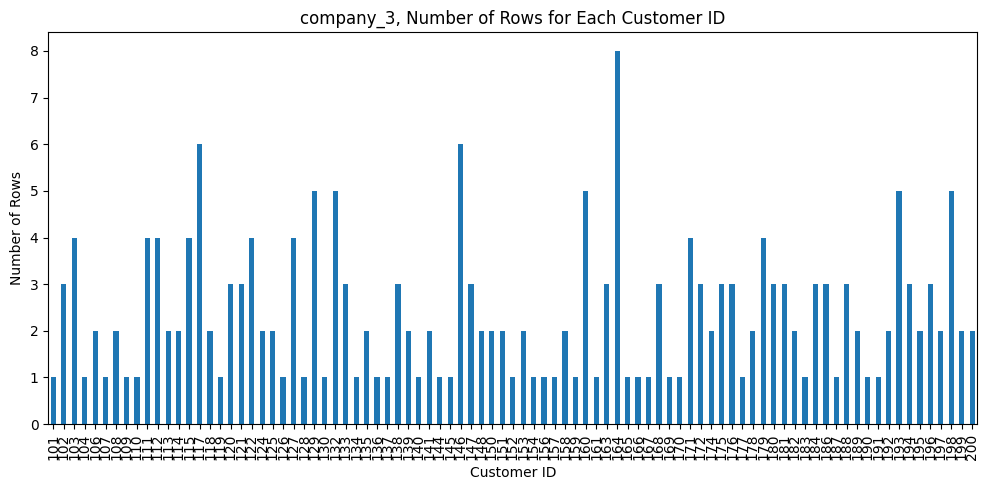

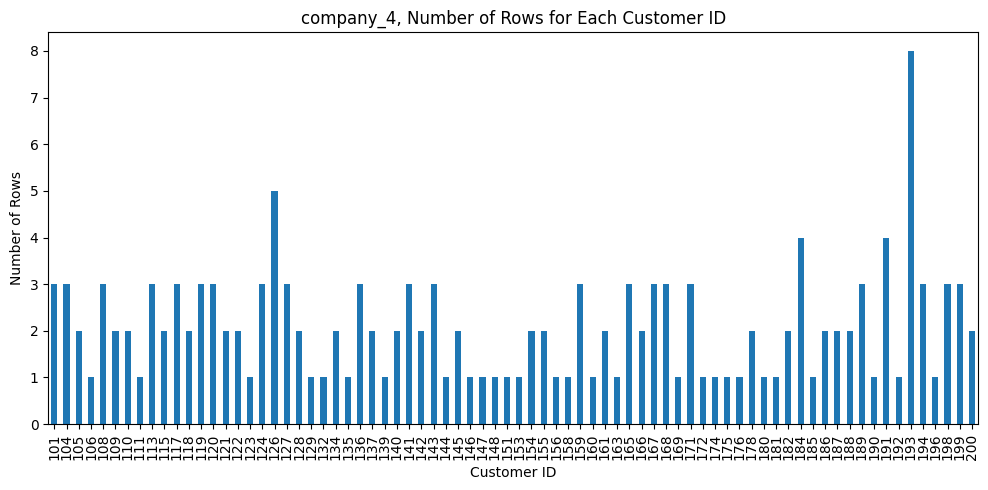

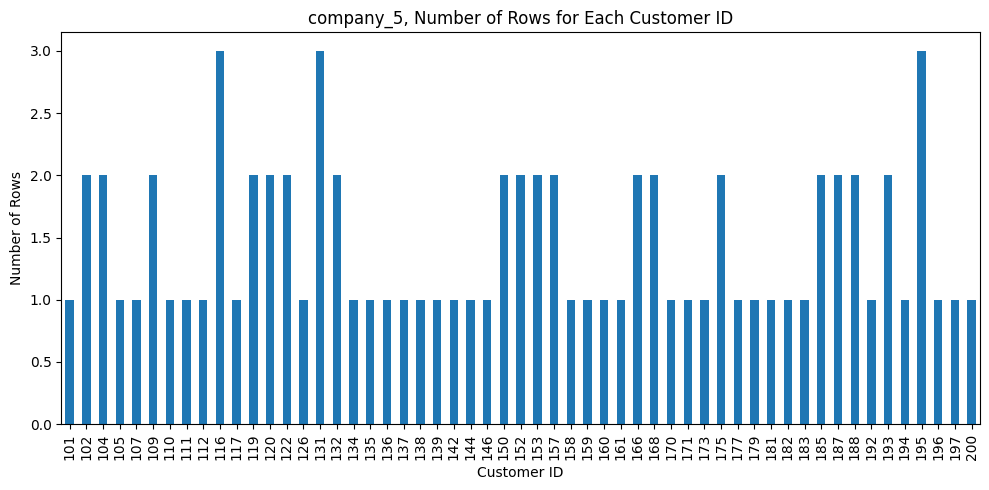

In [47]:

for company_id in OB_df['company_id'].unique():
    grouped_company_customer = OB_df[OB_df['company_id']==company_id].groupby(['customer_id']).size()
    # Plotting the distribution for each [company_id, customer_id]
    # plt.subplots(i, 1)
    plt.figure(figsize=(10, 5))
    grouped_company_customer.plot(kind='bar')
    plt.title(f'{company_id}, Number of Rows for Each Customer ID')
    plt.xlabel('Customer ID')
    plt.ylabel('Number of Rows')
    plt.tight_layout()
    plt.show()


# Observation
None

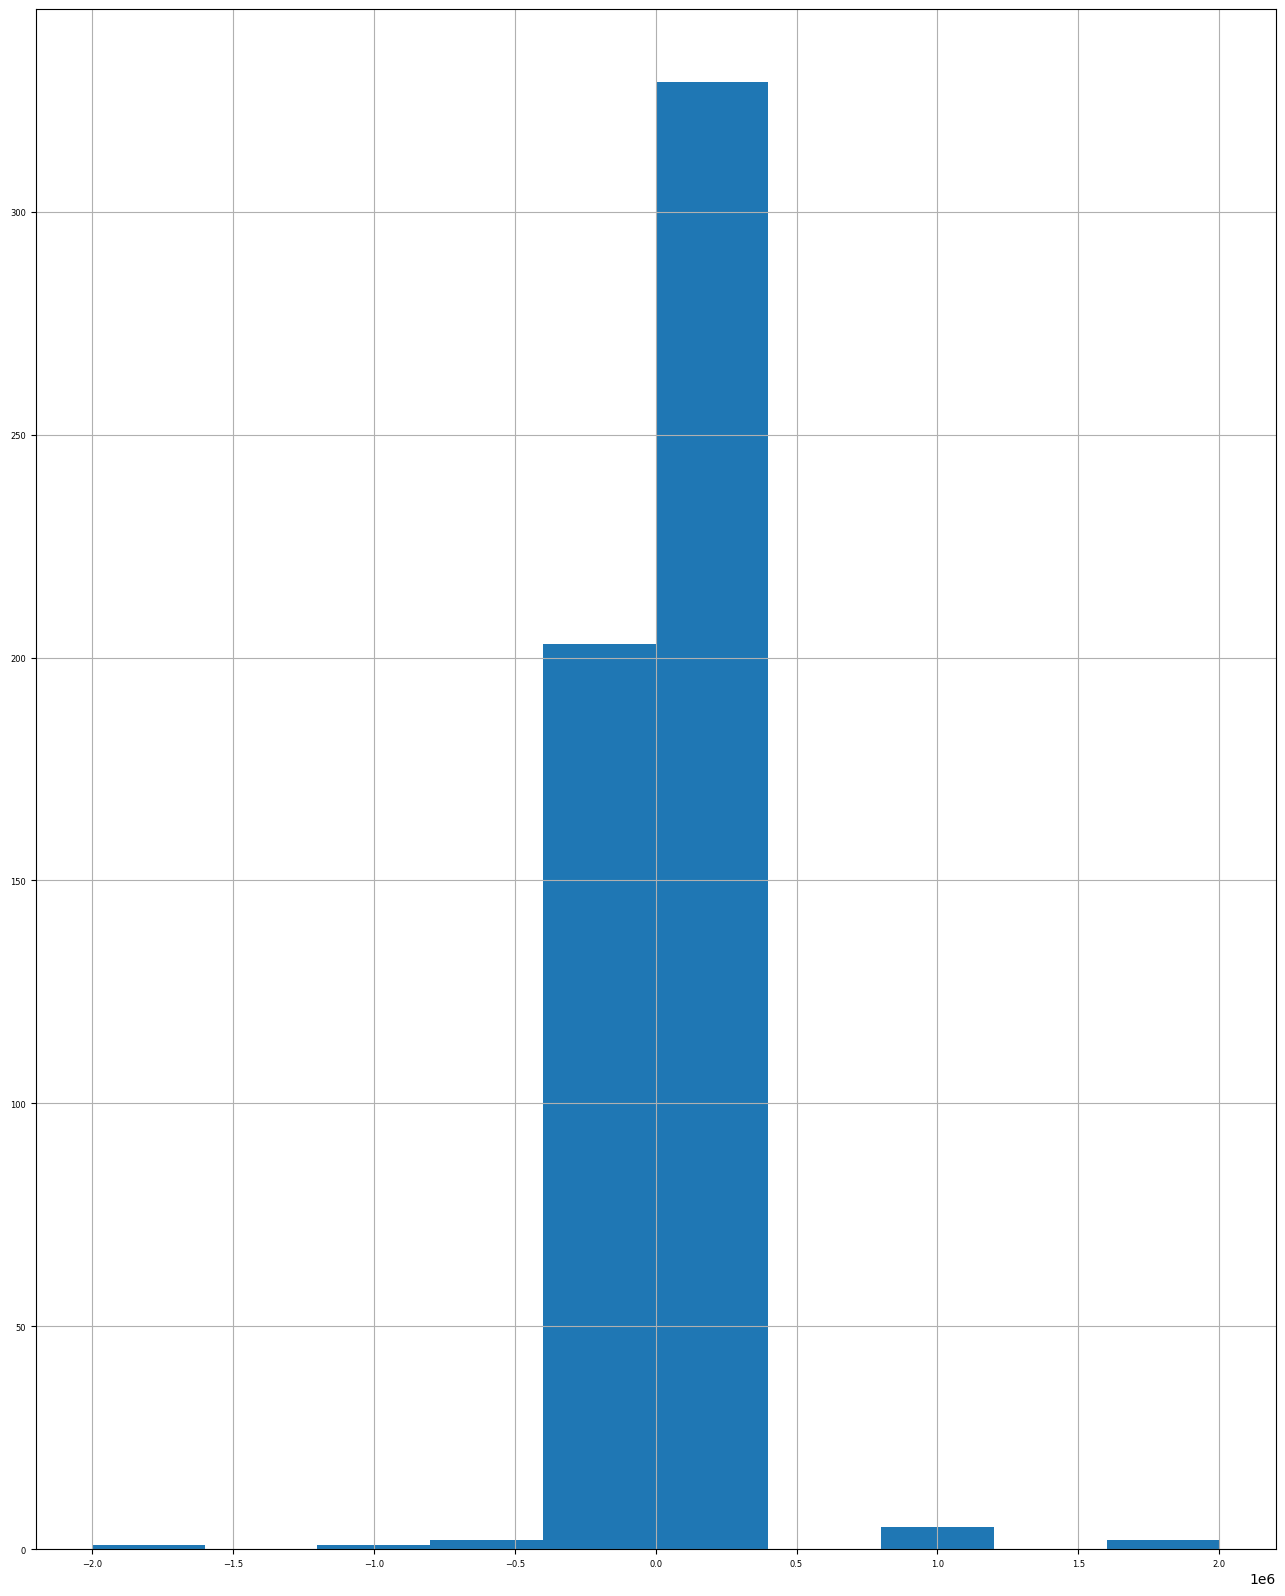

In [192]:

OB_df['transaction_amount'].hist(figsize=(16, 20), bins=10, xlabelsize=6, ylabelsize=6);


# Observation
this hist show that we have outliers, since most of the total_amount values are between -0.5 to 0.5, but we have few samples that have values out of range
## conclution
It's not a good idea to fill the None values with the mean. since we have outliers in our data

In [110]:
! pip install seaborn

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 6.5 MB/s eta 0:00:007.8 MB/s eta 0:00:01
  DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


<Axes: xlabel='transaction_amount'>

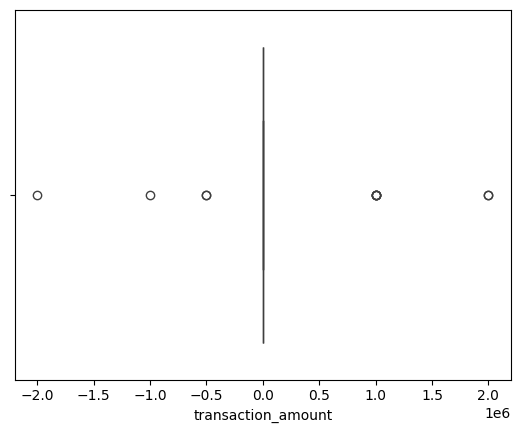

In [213]:
import seaborn as sns     
sns.boxplot(x=OB_df['transaction_amount'])

In [222]:
def outlier_thresholds (dataframe, column, q1=0.25, q3=0.75) :
    quartile1 = dataframe[column].quantile(q1)
    quartile3 = dataframe[column].quantile(q3)
    interquartile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquartile_range
    low_limit = quartile1 - 1.5 * interquartile_range
    return low_limit, up_limit

# Checking Outliers
def check_outlier(dataframe, column):
    low_limit, up_limit = outlier_thresholds(dataframe, column)
    outliers = (dataframe[column] > up_limit) | (dataframe[column] < low_limit)
    if outliers.any():
        return True
    else:
        return False

# Removing the outliers
def replace_with_thresholds (dataframe, column) :
    low_limit , up_limit = outlier_thresholds(dataframe, column)
    dataframe.loc[(dataframe[column] < low_limit), column] = low_limit
    dataframe.loc[(dataframe[column] > up_limit), column] = up_limit

In [223]:
print('before outlier check', check_outlier(OB_df, 'transaction_amount'))
replace_with_thresholds(OB_df, 'transaction_amount')
print('after outlier check', check_outlier(OB_df, 'transaction_amount'))

before outlier check True
after outlier check False


## Sence check outlier fix

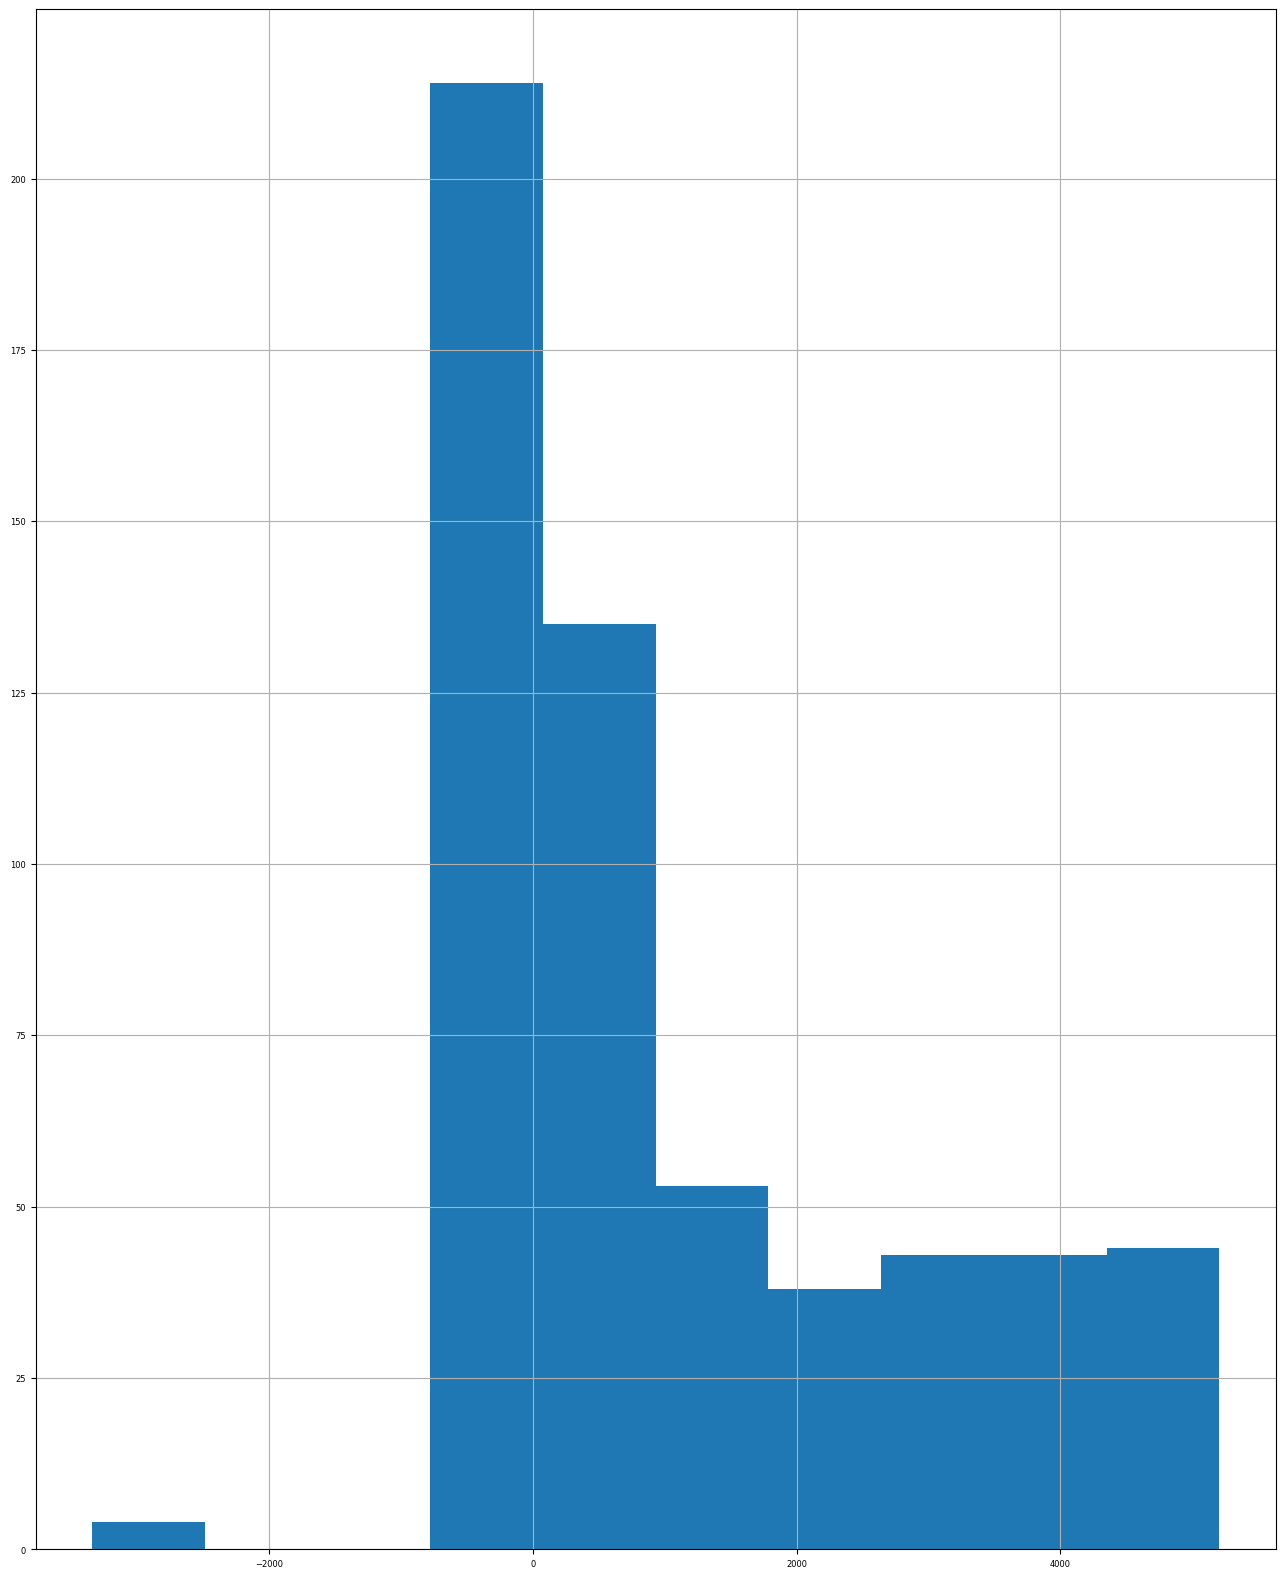

In [224]:

OB_df['transaction_amount'].hist(figsize=(16, 20), bins=10, xlabelsize=6, ylabelsize=6);


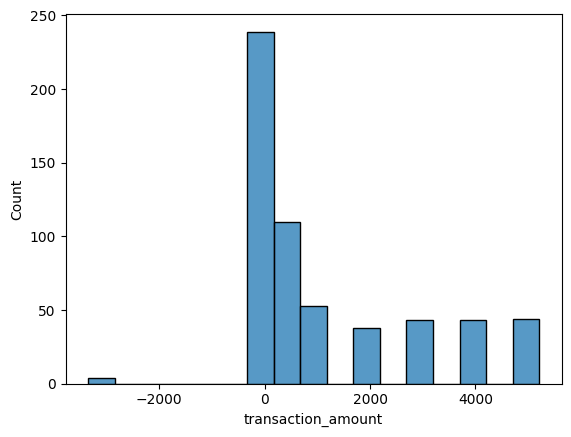

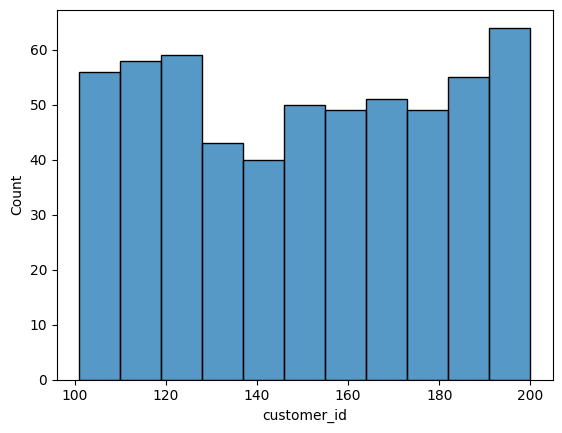

In [225]:
#histogram to understand the distribution
import warnings
from matplotlib import pyplot as plt
warnings.filterwarnings("ignore")
for i in OB_df.select_dtypes(include="number").columns:
    sns.histplot(data=OB_df,x=i)
    plt.show()

<Axes: xlabel='transaction_amount'>

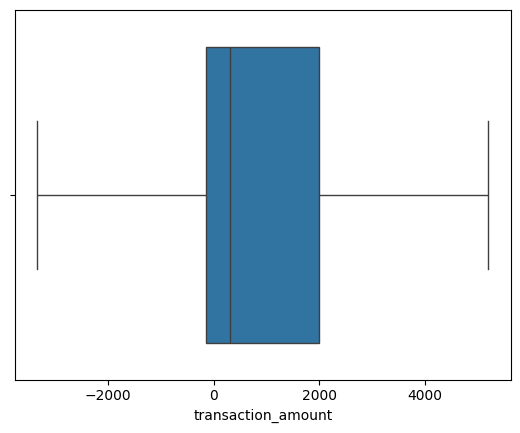

In [226]:
import seaborn as sns     
sns.boxplot(x=OB_df['transaction_amount'])

## Generate dummy numerical columns

In [197]:
OB_df = pd.get_dummies(OB_df, columns=['company_id', 'transaction_description', 'payment_method'])

In [198]:
boolean_columns = OB_df.select_dtypes(include=['bool']).columns
OB_df[boolean_columns] = OB_df[boolean_columns].astype(int)
OB_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 543 entries, 0 to 599
Data columns (total 57 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   transaction_amount                                        543 non-null    float64
 1   customer_id                                               543 non-null    int64  
 2   company_id_company_1                                      543 non-null    int64  
 3   company_id_company_2                                      543 non-null    int64  
 4   company_id_company_3                                      543 non-null    int64  
 5   company_id_company_4                                      543 non-null    int64  
 6   company_id_company_5                                      543 non-null    int64  
 7   transaction_description_Accessory revenue                 543 non-null    int64  
 8   transaction_description_B

In [200]:
OB_df.to_csv('clean_revenue_data.csv', index=False)